In [ ]:
!pip install -q transformers datasets rouge-score

     |████████████████████████████████| 2.6 MB 4.0 MB/s 
     |████████████████████████████████| 264 kB 54.1 MB/s 
     |████████████████████████████████| 636 kB 61.1 MB/s 
     |████████████████████████████████| 895 kB 59.3 MB/s 
     |████████████████████████████████| 3.3 MB 79.0 MB/s 
     |████████████████████████████████| 243 kB 79.8 MB/s 
     |████████████████████████████████| 118 kB 97.8 MB/s 


In [1]:
#install spacy large language model. (Colab needs to be restarted/)
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=fa3dee5ee21093635b86e1cfa1c9993d1b6a32f2a082365289c74e79bfb4b9dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6mhtxu_/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
  

import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_lg')

## CNN/Daily Mail Dataset

The CNN/DailyMail dataset contains 
- 287K documents, each with 3-4 highlights that summarize the contents of the article. 
- We can download this from the Tensorflow Datasets library


In [2]:
cnn_ds = tfds.as_numpy(tfds.load(
    'cnn_dailymail',
    split='test',
    batch_size=-1
)) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteHKUUJA/cnn_dailymail-train.tfrecord


  0%|          | 0/287113 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteHKUUJA/cnn_dailymail-validation.tfrecord


  0%|          | 0/13368 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteHKUUJA/cnn_dailymail-test.tfrecord


  0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [3]:
cnn_df = pd.DataFrame(cnn_ds)
cnn_df.highlights = cnn_df.highlights.apply(lambda x: x.decode('utf-8')) 
cnn_df["summary"] = cnn_df.highlights.apply(lambda x: "".join(x.split("\n")) ) 
cnn_df.article = cnn_df.article.apply(lambda x: x.decode('utf-8')) 
cnn_df["art_sents"] = cnn_df.article.apply(lambda x: len([x for x in nlp(x).sents])) 
cnn_df

,article,highlights,summary,art_sents
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,Experts question if packed out planes are put...,16
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,Drunk teenage boy climbed into lion enclosure ...,18
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,Nottingham Forest are close to extending Dougi...,6
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,Fiorentina goalkeeper Neto has been linked wit...,19
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...","Tell-all interview with the reality TV star, 6...",42
...,...,...,...,...
11485,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...,Oxford scientists say a Mercury-like body stru...,33
11486,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...,Man accused of helping former lover kill woman...,41
11487,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...,Marianne Power tried the tuning fork facial at...,96
11488,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...,Brooklyn Nets beat the Portland Trail Blazers ...,9


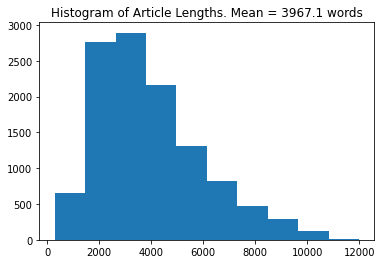

In [4]:
art_lengths = [ len(x) for x in cnn_df.article] 
plt.hist(art_lengths);
plt.title("Histogram of Article Lengths. Mean = " + str(round(sum(art_lengths)/ len(art_lengths),1)) + " words" );

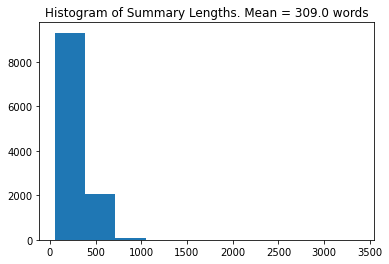

In [5]:
sum_lengths = [ len(x) for x in cnn_df.summary] 
plt.hist(sum_lengths);
plt.title("Histogram of Summary Lengths. Mean = " + str(round(sum(sum_lengths)/ len(sum_lengths),1)) + " words" );

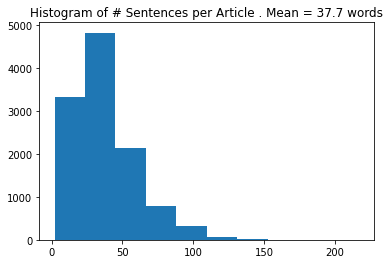

In [6]:
# art_lengths = [ len(x) for x in cnn_df.article] 
plt.hist(cnn_df.art_sents);
plt.title("Histogram of # Sentences per Article . Mean = " + str(round(sum(cnn_df.art_sents)/ len(cnn_df.art_sents),1)) + " words" );

## Export Data Subset for Reuse 

- We will write the test and train datasets to disc to avoid new downloads each time we reuse them in subsequent notebooks.

In [ ]:
import pickle
import os



def save_pickle(arr, path):
  with open(path, 'wb') as handle:
    pickle.dump(arr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_df =  pd.DataFrame(tfds.as_numpy(tfds.load( 'cnn_dailymail', split='test', batch_size=-1)))
train_df = pd.DataFrame(tfds.as_numpy(tfds.load( 'cnn_dailymail', split='train', batch_size=-1)))

test_df.highlights = test_df.highlights.apply(lambda x: x.decode('utf-8')) 
train_df.highlights = train_df.highlights.apply(lambda x: x.decode('utf-8')) 

test_df.article = test_df.article.apply(lambda x: x.decode('utf-8')) 
train_df.article = train_df.article.apply(lambda x: x.decode('utf-8')) 

test_df.shape, train_df.shape

((11490, 2), (287113, 2))

In [ ]:
os.makedirs("data/", exist_ok=True) 
os.makedirs("data/test", exist_ok=True) 
os.makedirs("data/train", exist_ok=True) 

test_df.to_json("data/test/test.json")
train_df.to_json("data/train/train.json")


In [ ]:
#define a directory to save data 
sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/"
!gsutil cp -r data $sum_dir 

Copying file://data/test/test.json...
Copying file://data/train/train.json...
-
Operation completed over 2 objects/1.2 GiB.                                      
